# Computational Genomics - Task 3

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

In [2]:
# %pip install pyBigWig
# %pip install biopython
# %pip install pyranges

### Opening and visualizing a 1D signal track from a bigWig file

In [3]:
import pyBigWig

bw = pyBigWig.open("ENCFF578TBN_FOCchange.bigWig")

In [4]:
bw.chroms()

{'chrUn_KI270337v1': 1121,
 'chrUn_KI270749v1': 158759,
 'chr1_KI270713v1_random': 40745,
 'chr13': 114364328,
 'chr12': 133275309,
 'chr11': 135086622,
 'chr10': 133797422,
 'chr17': 83257441,
 'chr16': 90338345,
 'chr15': 101991189,
 'chr14': 107043718,
 'chrUn_GL000218v1': 161147,
 'chr19': 58617616,
 'chr18': 80373285,
 'chrUn_GL000219v1': 179198,
 'chr17_KI270729v1_random': 280839,
 'chrUn_GL000213v1': 164239,
 'chrUn_KI270746v1': 66486,
 'chrUn_KI270516v1': 1300,
 'chrUn_KI270747v1': 198735,
 'chrUn_GL000214v1': 137718,
 'chr9_KI270720v1_random': 39050,
 'chrUn_KI270538v1': 91309,
 'chrEBV': 171823,
 'chr15_KI270727v1_random': 448248,
 'chrUn_KI270333v1': 2699,
 'chrUn_KI270435v1': 92983,
 'chrUn_KI270741v1': 157432,
 'chrUn_KI270743v1': 210658,
 'chrUn_KI270744v1': 168472,
 'chr22_KI270732v1_random': 41543,
 'chrUn_GL000216v2': 176608,
 'chrUn_GL000195v1': 182896,
 'chrUn_KI270742v1': 186739,
 'chr14_GL000194v1_random': 191469,
 'chrUn_KI270590v1': 4685,
 'chrUn_KI270751v1': 150

In [5]:
bw.header()

{'version': 4,
 'nLevels': 10,
 'nBasesCovered': 3094819913,
 'minVal': 0,
 'maxVal': 289,
 'sumData': 1292406559,
 'sumSquared': 7358208942}

In [6]:
# Study the bw.stats and bw. values method

In [7]:
bw.stats("chr3", 1_000_000, 1_100_000, type="mean", nBins=10)

[0.439326752541282,
 0.4287509563099254,
 0.539603349165483,
 0.3238440002441406,
 0.3570554568204013,
 0.37017324454567646,
 0.3308227523803711,
 0.3962791711980646,
 0.9085139198996803,
 0.4335125288529829]

In [8]:
bw.values("chr3", 2_000_000, 2_000_100, numpy=True).shape

(100,)

## Finding CTCF motifs

Let's use a very simple method of finding potential CTCF binding sites, by using a PSSM matrix to search for binding motifs.
We'll use https://biopython.org/docs/dev/Tutorial/chapter_motifs.html

Alternatively, use the pre-caclulated binding site locations in the file ENCFF138REW_GGCCACYAGRKGGCGSYV.bed

In [9]:
import gzip
from Bio import SeqIO, motifs

with gzip.open("./Homo_sapiens.GRCh38.dna.chromosome.1.fa.gz", "rt") as f:
    record_dict = SeqIO.to_dict(SeqIO.parse(f, "fasta"))

print(f"Sequences: {record_dict.keys()}")
rec = record_dict["1"]
print(f'name="{rec.name}", id="{rec.id}", description="{rec.description}"')
chr1_seq = rec.seq
print(len(chr1_seq), type(chr1_seq))

Sequences: dict_keys(['1'])
name="1", id="1", description="1 dna:chromosome chromosome:GRCh38:1:1:248956422:1 REF"
248956422 <class 'Bio.Seq.Seq'>


In [10]:
with open("./MA0139.1.jaspar") as f:
    m = motifs.read(f, fmt="jaspar")
m.pseudocounts = 1.0

print(type(m))
print(m)
print(f"PWM:\n{m.pwm}")
print(f"PSSM:\n{m.pssm}")

<class 'Bio.motifs.jaspar.Motif'>
TF name	CTCF
Matrix ID	MA0139.1
Matrix:
        0      1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16     17     18
A:  87.00 167.00 281.00  56.00   8.00 744.00  40.00 107.00 851.00   5.00 333.00  54.00  12.00  56.00 104.00 372.00  82.00 117.00 402.00
C: 291.00 145.00  49.00 800.00 903.00  13.00 528.00 433.00  11.00   0.00   3.00  12.00   0.00   8.00 733.00  13.00 482.00 322.00 181.00
G:  76.00 414.00 449.00  21.00   0.00  65.00 334.00  48.00  32.00 903.00 566.00 504.00 890.00 775.00   5.00 507.00 307.00  73.00 266.00
T: 459.00 187.00 134.00  36.00   2.00  91.00  11.00 324.00  18.00   3.00   9.00 341.00   8.00  71.00  67.00  17.00  37.00 396.00  59.00



PWM:
        0      1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16     17     18
A:   0.10   0.18   0.31   0.06   0.01   0.81   0.04   0.12   0.93   0.01   0.37   0.06   0.01   0.06  

We find the match scores at each location...

In [11]:
scores = m.pssm.calculate(chr1_seq)
scores.shape

(248956404,)

In [12]:
good_scores = ~np.isnan(scores) & ~np.isinf(scores)
good_scores.sum(), good_scores.mean()

(230478377, 0.9257780611259151)

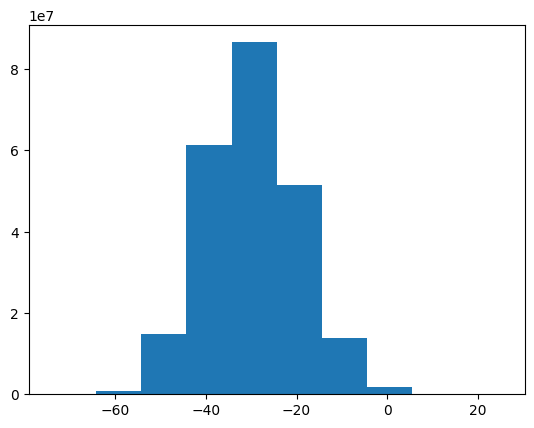

In [13]:
plt.hist(scores[good_scores]);

...but what is a "good" score?

In [14]:
score_dist = m.pssm.distribution(precision=10**4)
threshold = score_dist.threshold_fpr(0.0001)
print(f"{threshold:.3}")

8.42


In [15]:
filt_scores = scores[good_scores & (scores >= threshold)]
filt_scores_pos = np.flatnonzero(good_scores & (scores >= threshold))
filt_scores.shape

(24315,)

Let's get the coords of motifs, and write them into a file:

In [16]:
motif_coorsds = pd.DataFrame(
    {"chromosome": "chr1", "start": filt_scores_pos, "end": filt_scores_pos + len(m)}
)
motif_coorsds

,chromosome,start,end
0,chr1,16650,16669
1,chr1,17091,17110
2,chr1,18119,18138
3,chr1,22561,22580
4,chr1,34941,34960
...,...,...,...
24310,chr1,248944298,248944317
24311,chr1,248944481,248944500
24312,chr1,248944540,248944559
24313,chr1,248944598,248944617


In [17]:
motif_coorsds.to_csv("motif_coords.bed", index=False, header=False, sep="\t")

**Task: Visualize parts of the signal for some loaction**

## Finding overlaps

Let's find peaks that contain the motifs.

In [18]:
import pyranges as pr  # https://pyranges.readthedocs.io/

binding_motifs = pr.read_bed("motif_coords.bed")
binding_motifs

/home/michade/mambaforge/envs/sci/lib/python3.11/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}


,Chromosome,Start,End
0,chr1,16650,16669
1,chr1,17091,17110
2,chr1,18119,18138
3,chr1,22561,22580
4,chr1,34941,34960
...,...,...,...
24310,chr1,248944298,248944317
24311,chr1,248944481,248944500
24312,chr1,248944540,248944559
24313,chr1,248944598,248944617


In [19]:
peaks = pr.read_bed("./ENCFF960ZGP_optThreshPeaks.bed")
peaks = peaks[["Chromosome", "Start", "End"]]
peaks

/home/michade/mambaforge/envs/sci/lib/python3.11/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}


,Chromosome,Start,End
0,chr1,41575742,41575958
1,chr1,111738939,111739155
2,chr1,164891634,164891850
3,chr1,35288057,35288273
4,chr1,32242568,32242784
...,...,...,...
43860,chrX,133792535,133792724
43861,chrX,10119460,10119874
43862,chrX,12946847,12947085
43863,chrX,100768813,100769037


In [20]:
peaks.overlap(binding_motifs)

,Chromosome,Start,End
0,chr1,164891634,164891850
1,chr1,98661689,98661905
2,chr1,2311565,2311781
3,chr1,90046773,90046989
4,chr1,21900219,21900435
...,...,...,...
1795,chr1,9627016,9627283
1796,chr1,114346566,114346817
1797,chr1,159161069,159161298
1798,chr1,150979542,150979773


**Task**: Generate statistics on the overlaps, visualize and inspect them in IGV.